# Dropout prediction and rule mining for Sozialwissenschaften

## Dropout when no exams in last three semesters

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

In [3]:
sql = "sql/sw_base_modules_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df


,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,EV_AP_Bestanden,EV_AP_Note,EV_AP_Versuche,EV2_AP_Bestanden,EV2_AP_Note,EV2_AP_Versuche,Sozi_AP_Bestanden,Sozi_AP_Note,Sozi_AP_Versuche,Polit_AP_Bestanden,Polit_AP_Note,Polit_AP_Versuche,Komm_AP_Bestanden,Komm_AP_Note,Komm_AP_Versuche,Dropout
0,1988,weiblich,1,20,1,2.7,1,1,3.7,2,0,5.0,2,0,5.0,2,1,4.0,1,1
1,1989,männlich,1,21,1,3.7,2,1,2.3,1,1,4.0,2,1,4.0,1,1,4.0,1,0
2,1989,weiblich,0,21,1,1.7,1,1,2.0,1,1,3.3,1,1,2.0,1,1,3.7,1,0
3,1991,männlich,1,19,1,1.7,2,1,1.7,1,1,3.0,1,1,2.3,1,1,3.0,1,0
4,1990,weiblich,1,20,1,1.7,1,1,1.7,1,1,2.3,1,1,2.3,1,1,3.7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,1998,männlich,1,20,1,2.7,1,1,4.0,1,1,4.0,1,0,5.0,1,0,5.0,1,1
917,1997,weiblich,1,21,1,2.7,1,0,5.0,0,0,5.0,0,0,5.0,0,0,5.0,1,1
918,1998,weiblich,1,20,1,3.3,2,0,5.0,0,0,5.0,0,0,5.0,1,0,5.0,1,1
919,1998,weiblich,1,20,1,3.7,1,0,5.0,0,0,5.0,0,0,5.0,0,0,5.0,0,1


In [4]:
def print_metric(cols, df):
    rows = len(df)
    for col in cols:
        count = len(df[df[col]==1])
        print(f"{col}:", count, f"({count*100./rows} %)")

In [5]:
print_metric(["Dropout", "EV_AP_Bestanden", "Polit_AP_Bestanden", "Sozi_AP_Bestanden", "Komm_AP_Bestanden"], df)

Dropout: 327 (35.504885993485345 %)
EV_AP_Bestanden: 846 (91.85667752442997 %)
Polit_AP_Bestanden: 734 (79.69598262757872 %)
Sozi_AP_Bestanden: 731 (79.37024972855592 %)
Komm_AP_Bestanden: 728 (79.04451682953312 %)


In [6]:
# Preprocess data
df_classification = df.copy(deep=True)
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)
df_classification.head()

,Deutsch,AlterEinschreibung,EV_AP_Bestanden,EV_AP_Note,EV_AP_Versuche,EV2_AP_Bestanden,EV2_AP_Note,EV2_AP_Versuche,Sozi_AP_Bestanden,Sozi_AP_Note,...,Polit_AP_Bestanden,Polit_AP_Note,Polit_AP_Versuche,Komm_AP_Bestanden,Komm_AP_Note,Komm_AP_Versuche,Dropout,Männlich,Weiblich,Divers
0,1,20,1,2.7,1,1,3.7,2,0,5.0,...,0,5.0,2,1,4.0,1,1,0,1,0
1,1,21,1,3.7,2,1,2.3,1,1,4.0,...,1,4.0,1,1,4.0,1,0,1,0,0
2,0,21,1,1.7,1,1,2.0,1,1,3.3,...,1,2.0,1,1,3.7,1,0,0,1,0
3,1,19,1,1.7,2,1,1.7,1,1,3.0,...,1,2.3,1,1,3.0,1,0,1,0,0
4,1,20,1,1.7,1,1,1.7,1,1,2.3,...,1,2.3,1,1,3.7,1,0,0,1,0


In [7]:
print_metric(["Männlich", "Weiblich", "Divers"], df_classification)

Männlich: 323 (35.07057546145494 %)
Weiblich: 598 (64.92942453854506 %)
Divers: 0 (0.0 %)


### Training the model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [9]:
def eval_model(clf):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)


In [10]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf)


# Trainset
Balanced accuracy: 0.9674786643466733
Area under curve: 0.9674786643466733
Confusion Matrix (tn, fp, fn, tp):
[[440   7]
 [ 12 231]]
# Testset
Balanced accuracy: 0.8418367346938775
Area under curve: 0.8418367346938775
Confusion Matrix (tn, fp, fn, tp):
[[132  15]
 [ 18  66]]


### Display learned rules

In [11]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

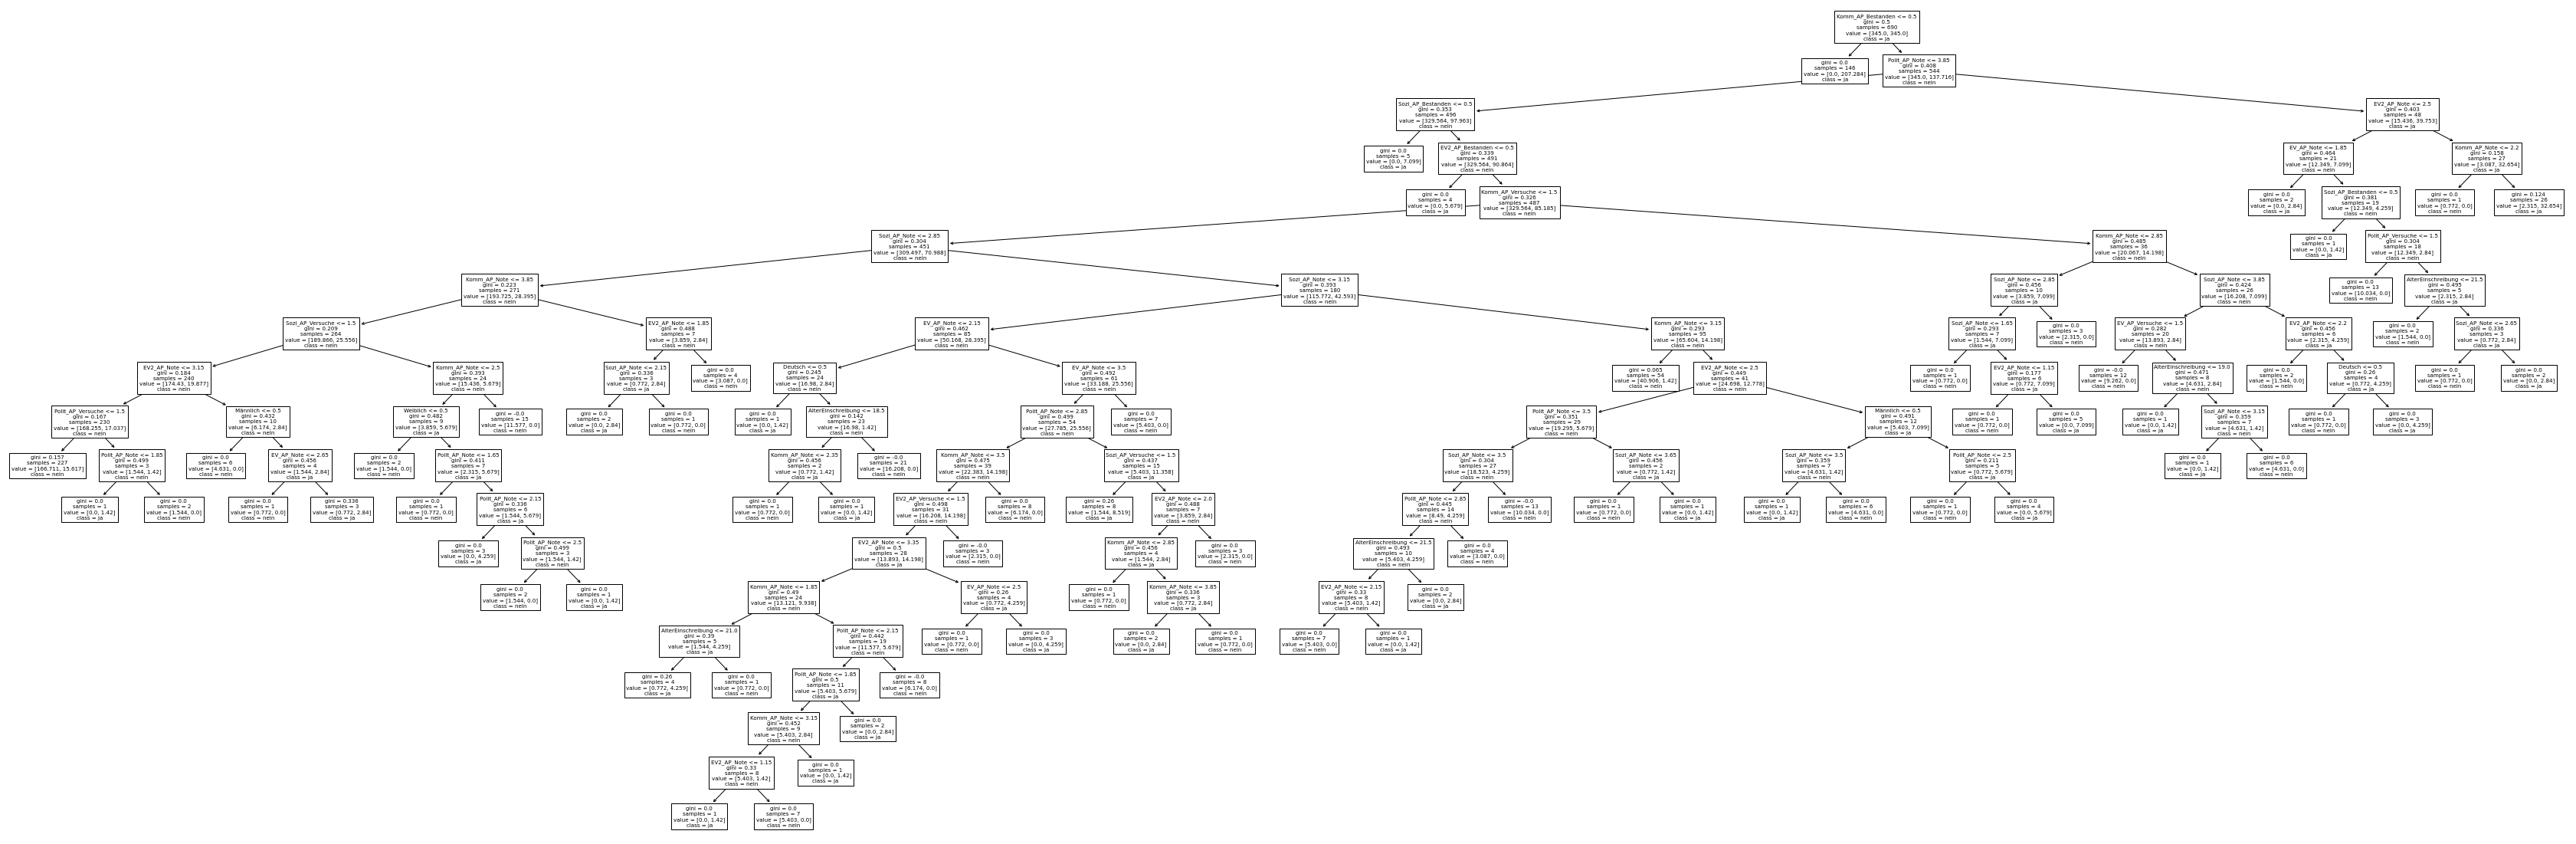

In [12]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

### Post pruning

In [13]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00113954, 0.00139013, 0.00144928, 0.00144928,
        0.00144928, 0.00158919, 0.001726  , 0.00175901, 0.00175901,
        0.00183756, 0.00184303, 0.00189243, 0.00189394, 0.00189394,
        0.00190857, 0.00193784, 0.00196947, 0.00198948, 0.00208263,
        0.0022537 , 0.0022779 , 0.00234841, 0.0023941 , 0.00245389,
        0.00274136, 0.00291109, 0.00301821, 0.0030814 , 0.00314961,
        0.0032536 , 0.00326394, 0.00328599, 0.00365667, 0.00388592,
        0.00465478, 0.00503175, 0.01025311, 0.01098727, 0.01243334,
        0.03417925, 0.21470588]),
 'impurities': array([0.05907517, 0.06021471, 0.06160484, 0.06305412, 0.06595267,
        0.06740194, 0.07216952, 0.07562153, 0.07738054, 0.07913956,
        0.08281468, 0.08465771, 0.08655014, 0.08844408, 0.09033802,
        0.09224658, 0.09418443, 0.0961539 , 0.10013285, 0.10221548,
        0.11348399, 0.12031771, 0.12266612, 0.1394248 , 0.14187869,
        0.14736141, 0.15900575, 0.16504217, 0.17428637

Text(0, 0.5, 'Balanced Accuracy scores')

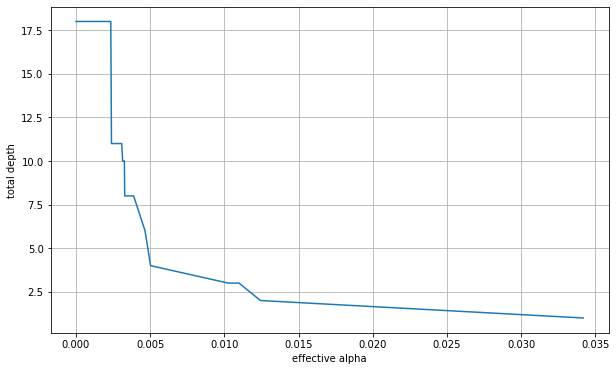

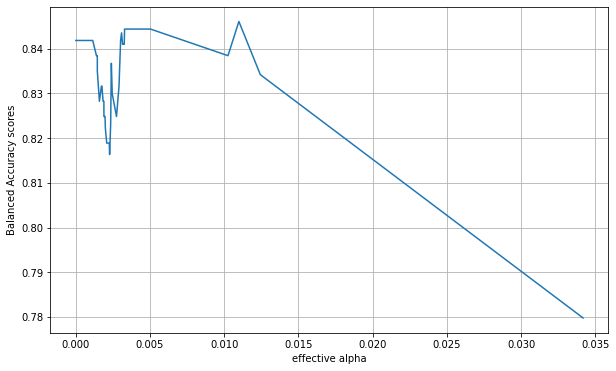

In [14]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

# Trainset
Balanced accuracy: 0.8356533267047808
Area under curve: 0.8356533267047809
Confusion Matrix (tn, fp, fn, tp):
[[427  20]
 [ 69 174]]
# Testset
Balanced accuracy: 0.8341836734693877
Area under curve: 0.8341836734693877
Confusion Matrix (tn, fp, fn, tp):
[[142   5]
 [ 25  59]]


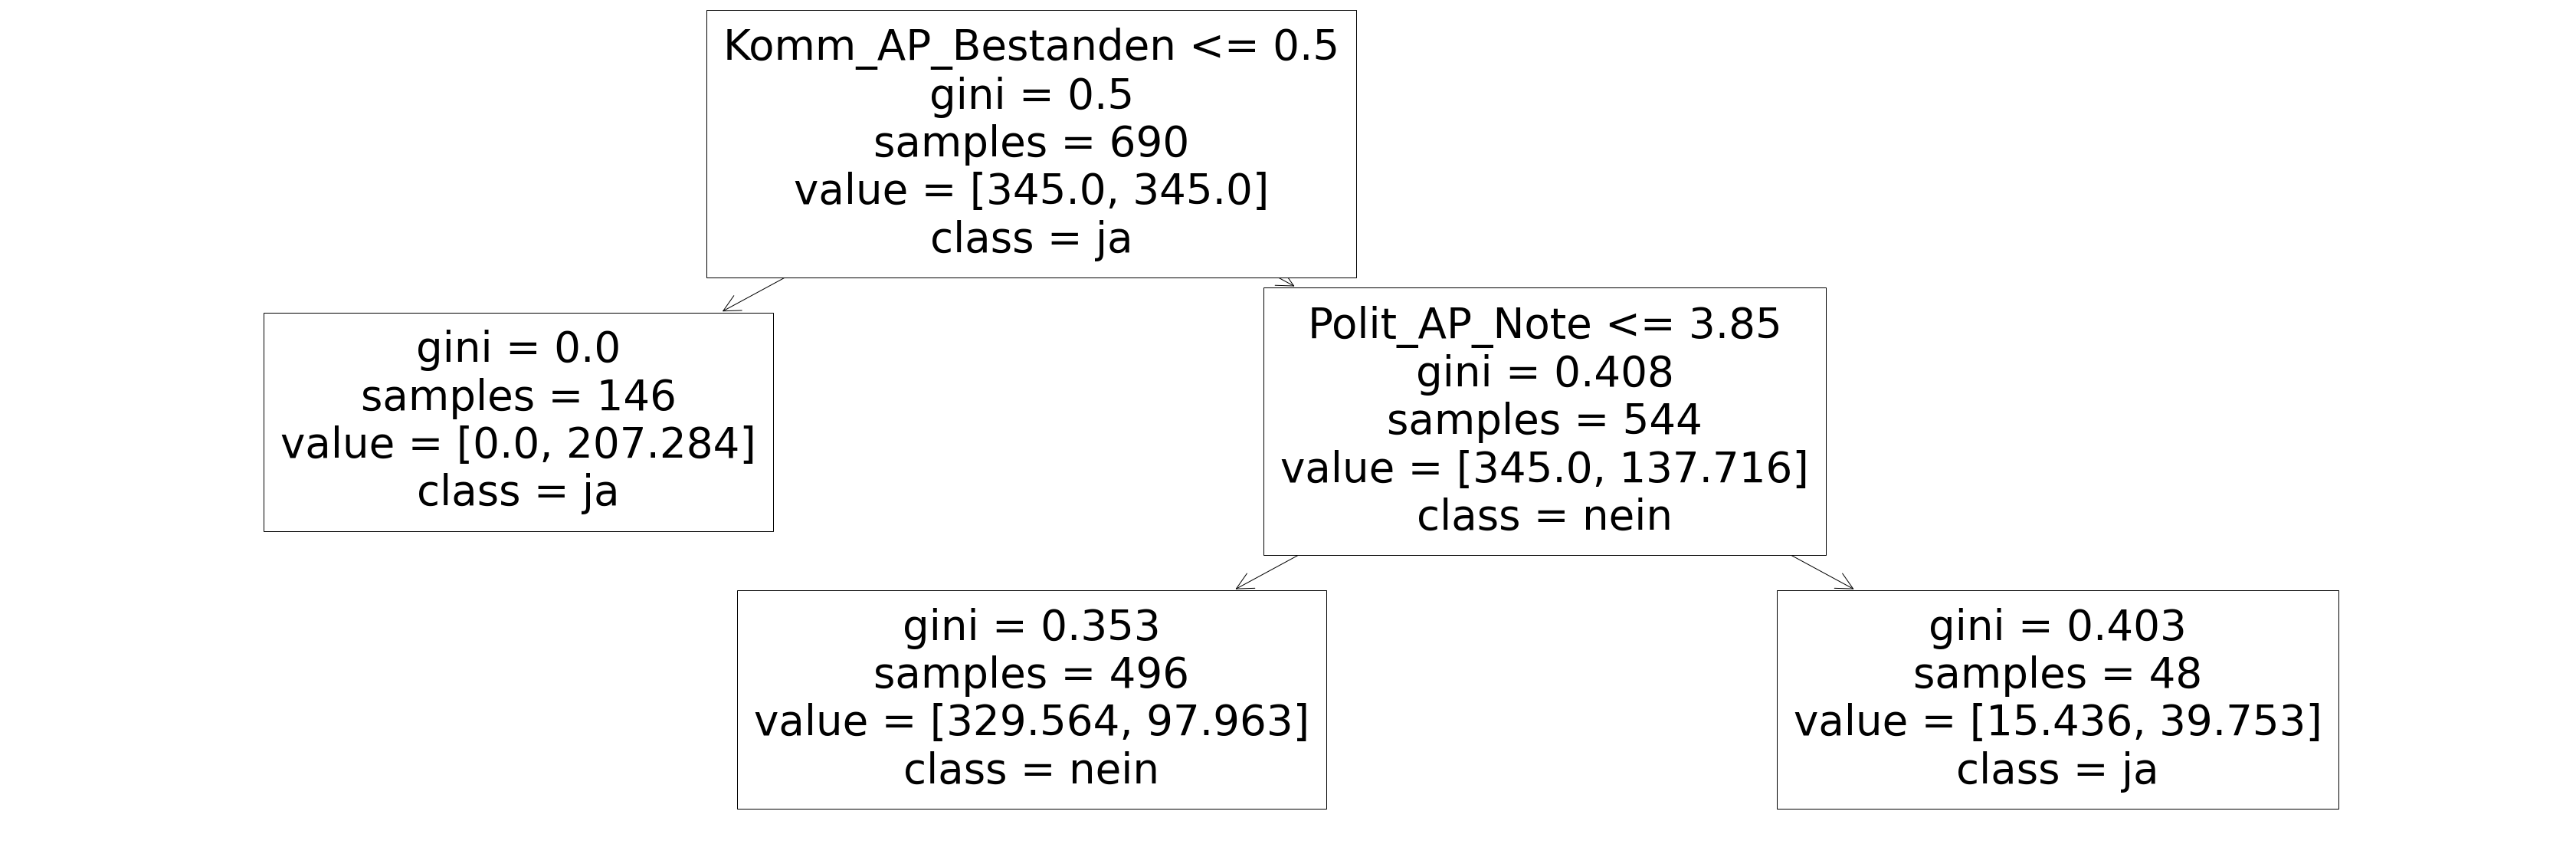

In [15]:
selected_ccp = 0.0125
# selected_ccp = 0.0024  # Alternative alpha with tree-depth 10, see below.


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

# Trainset
Balanced accuracy: 0.861780871102273
Area under curve: 0.8617808711022731
Confusion Matrix (tn, fp, fn, tp):
[[443   4]
 [ 65 178]]
# Testset
Balanced accuracy: 0.8443877551020408
Area under curve: 0.8443877551020408
Confusion Matrix (tn, fp, fn, tp):
[[145   2]
 [ 25  59]]


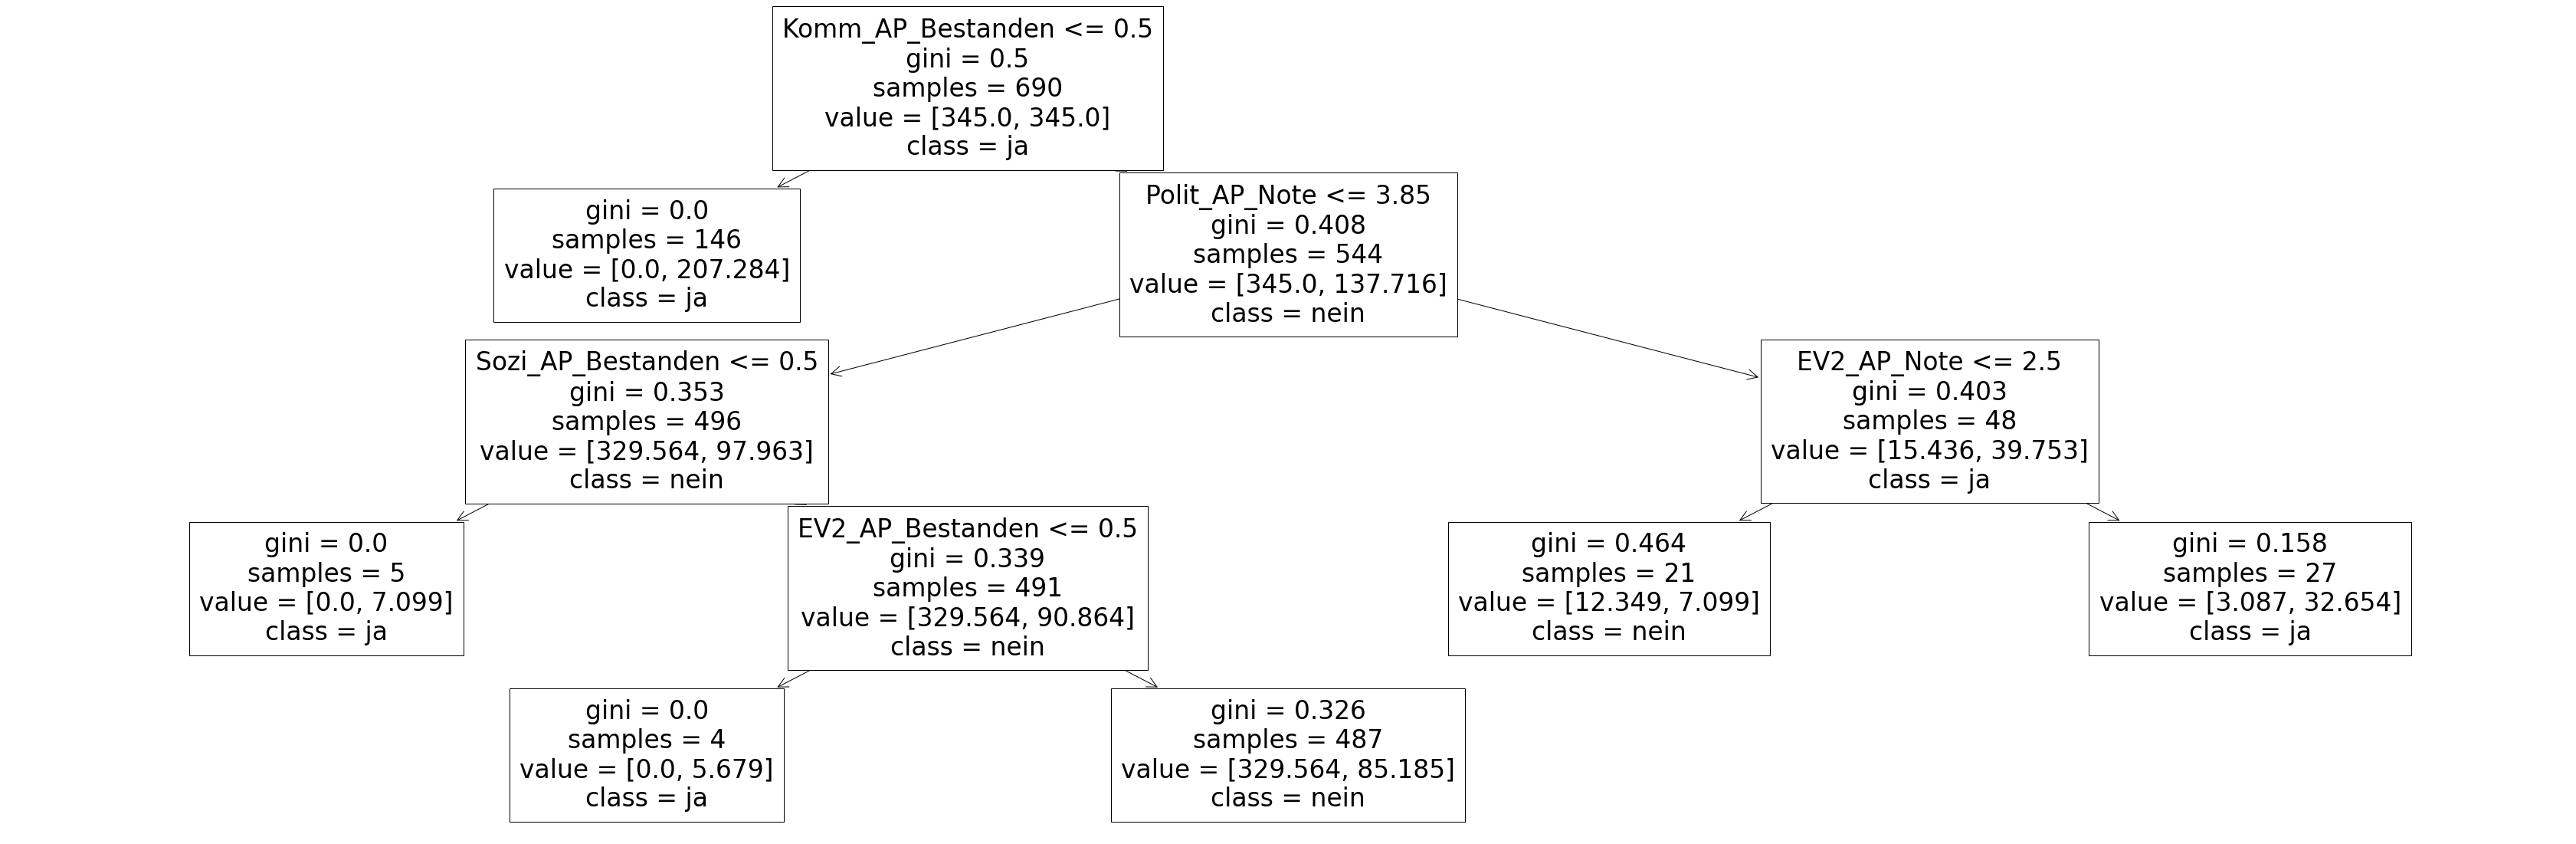

In [16]:
selected_ccp = 0.0051  

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()
